### Sampled 10 time steps in order to demonstrate that LM's output probabilities has a prominent tail when modeled in Zipfian log-log graph. (see the graph at the end)

In [ ]:
import argparse
import logging
import os
import random
from functools import partial
from operator import add

import torch
from pytorch_pretrained_bert import GPT2LMHeadModel, GPT2Tokenizer
from termcolor import colored
from toolz import compose, pipe
from tqdm import tqdm

from scipy import stats
from IPython.display import display_markdown, Markdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


seed = 0
random.seed(seed)
np.random.seed(seed)
torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)


#### Not sure what this data is, but looks like the beginning and end of sentences.

In [ ]:
inits, conts = [], []
with open("/data/gpt2-writingprompts-generations/gold.valid.txt", "r") as reader:
    for line in reader:
        init, cont = line.strip().split("\t")
        inits.append(init)
        conts.append(cont)

from random import sample
sampled_seqs = sample(list(zip(inits, conts)), 10)

#### Loads the GPT2 Model...

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_checkpoint = "/data/gpt2-finetuned-model/"
model = GPT2LMHeadModel.from_pretrained(model_checkpoint)
tokenizer = GPT2Tokenizer.from_pretrained(model_checkpoint)
model.to(device)
model.eval()
None

#### Not sure I understand what the following is doing... Let's say somehow encodes the sentences

In [ ]:
from toolz import pipe, curry
from functools import partial
map = curry(map)
enc_sents = list(pipe(
    sampled_seqs, map(" ".join), map(tokenizer.encode), map(partial(torch.tensor, dtype=torch.long))))

#### Sorts the sentences by decreasing order of probability???

In [ ]:
sorted_probs = []
for enc_sent in enc_sents:
    with torch.no_grad():
        sorted_probs.append(model(enc_sent.unsqueeze(0).to(device))[0].squeeze(0).softmax(1).sort(dim=1, descending=True))

In [ ]:
sampled_positions = [random.randint(0, l[0].shape[0]) for l in sorted_probs]
print(sampled_positions)

In [ ]:
position = sampled_positions[0]
probs = sorted_probs[0][0][position].cpu().numpy()

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, dpi=200, figsize=(15,8))
for i in range(9):
    position = sampled_positions[i]
    probs = sorted_probs[i][0][position].cpu().numpy()
    ax[i // 3, i % 3].plot(np.log(np.arange(len(probs))), np.log(probs))
plt.show()

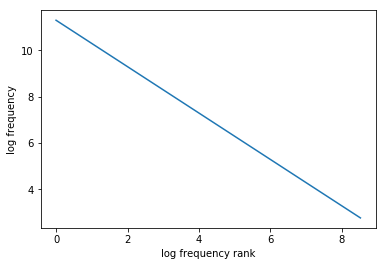

In [19]:
plt.plot([np.log(i) for i in range(1, 5000)], [np.log(80000/i) for i in range(1, 5000)])
plt.ylabel('log frequency')
plt.xlabel('log frequency rank')
plt.show()